In [1]:
import torch
import bgflow as bg
from tqdm.auto import tqdm

In [2]:
energy = bg.DoubleWellEnergy(dim=2)
N_UMBRELLAS = 10

class UmbrellaEnergy(bg.Energy):
    def __init__(self, energy, centers, force_constants):
        super().__init__(energy.event_shapes)
        self.delegate = energy
        self.centers = centers
        self.force_constants = force_constants
    
    def _energy(self, x):
        unbiased = self.delegate.energy(x)[..., 0]
        umbrella = ((x[...,0] - self.centers)**2).sum(dim=-1)
        bias = 0.5 * self.force_constants * umbrella
        return (unbiased + bias)[..., None]

In [3]:
target_energy = UmbrellaEnergy(
    energy, 
    centers=torch.linspace(-2, 2, N_UMBRELLAS),
    force_constants=100.*torch.ones(N_UMBRELLAS)
)

# test energy call
target_energy.energy(torch.randn(N_UMBRELLAS, 2)).shape

torch.Size([10, 1])

In [4]:
mcmc_step = bg.MCMCStep(
    target_energy,
    proposal=bg.GaussianProposal(noise_std=0.1),
    target_temperatures=1.0,
)

mcsampler = bg.IterativeSampler(
    bg.SamplerState(torch.randn(N_UMBRELLAS, 2)),
    [mcmc_step],
    stride=20,
    n_burnin=10,
    progress_bar=tqdm
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
samples = mcsampler.sample_to_cpu(5000, batch_size=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

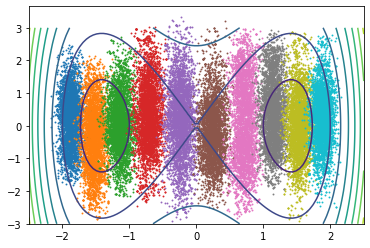

In [6]:
from matplotlib import pyplot as plt
from bgflow.utils.types import as_numpy

x = torch.linspace(-2.5,2.5,100)
y = torch.linspace(-3,3,100)
X, Y = torch.meshgrid(x,y)
Z = energy.energy(torch.stack([X,Y], dim=-1).reshape(-1,2))
plt.contour(as_numpy(X),as_numpy(Y), as_numpy(Z).reshape(100,100))

for i in range(N_UMBRELLAS):
    plt.scatter(samples[:,i,0], samples[:,i,1], s=0.8)